# * Business Growth Overview *

## Note :

Monitoring Job : 9.00 / 14.00 / 18.00 / 22.00

### Compare with VINSIGHT overview : 
- Total Revenue data about 2 days late.
- Target is lower than VINSIGHT (include "TDG" ?)
- %MoM, %WoW is different from VINSIGHT

## Import Data Source

In [53]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import configparser
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import reduce
# import datetime

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [54]:
''' Config '''

config = configparser.ConfigParser()
config.read('../my_config.ini')
config.sections()
as_week = config['PARAM']['as_week']

In [55]:
data_src = f"../data/raw/Raw-Agg Perf Nationwide_Wk {as_week}.csv"
df = pd.read_csv(data_src, low_memory=False)

cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 
        'ACTUAL_AS_OF', 'AGG_TYPE', 'RR_IND', 'GRY_IND', 'UOM', 'PERIOD', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'BASELINE_SNAP', 'BASELINE_AGG', 'PPN_TM']

df = df[cols]

''' Fix Metric CD list '''
prepaid_rev_cd_list = ['B1R000100CORP', 'DB1R000100', 'TB1R000100CORP'] # Prepaid Revenue, Prepaid Revenue : DTAC, Prepaid Revenue : TMH
postpaid_rev_cd_list = ['B2R000100', 'DB2R000100', 'TB2R000100'] # Postpaid Revenue, Postpaid Revenue : DTAC, Postpaid Revenue : TMH
tol_tvs_tdg_rev_cd_list = ['TB3R000100CORP', 'TB4R000100CORP'] # TOL Revenue, TVS Revenue

bg_rev_all_cd_list = prepaid_rev_cd_list + postpaid_rev_cd_list + tol_tvs_tdg_rev_cd_list

''' Fix Agg Column Name(Total Revenue) '''
bg_col_list = ['POST_DTAC', 'POST_TMH', 'PRE_DTAC', 'PRE_TMH', 'TOL', 'TVS']

In [56]:
df.shape

(492464, 24)

In [57]:
df = df[df['METRIC_CD'].isin(bg_rev_all_cd_list)]#.reset_index()

In [58]:
df[['METRIC_CD', 'METRIC_NAME']].drop_duplicates()

,METRIC_CD,METRIC_NAME
9,TB4R000100CORP,TVS Revenue
163,TB3R000100CORP,TOL Revenue
559,TB1R000100CORP,Prepaid Revenue : TMH
562,DB1R000100,Prepaid Revenue : DTAC
610,B1R000100CORP,Prepaid Revenue
983,DB2R000100,Postpaid Revenue : DTAC
984,TB2R000100,Postpaid Revenue : TMH
997,B2R000100,Postpaid Revenue


In [59]:
''' Find Metric '''

# df_metric = df.groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME']).size().reset_index()
df_agg_s = df[df['AGG_TYPE']=='S'].groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
df_agg_n = df.loc[df[df['AGG_TYPE']=='N'].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
df_agg_n = df_agg_n[['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]#.reset_index()
df_metric = pd.concat([df_agg_s, df_agg_n])
df_metric

# df_tmp = df_metric[df_metric['METRIC_GRP']=="Revenue"]
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")]#.reset_index()
# # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Sub")]#.reset_index()
# df_tmp = df_tmp[df_tmp['PRODUCT_GRP']=="TVS"]

# # df_tmp.to_excel('Prepaid_Metric.xlsx')
# df_tmp

,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,METRIC_NAME,AGG_TYPE,ACTUAL_SNAP,TARGET_SNAP
0,Revenue,Revenue,ALL,Postpaid,B2R000100,Postpaid Revenue,S,9.353606e+10,9.399694e+10
1,Revenue,Revenue,ALL,Prepaid,B1R000100CORP,Prepaid Revenue,S,5.466063e+10,5.348150e+10
2,Revenue,Revenue,DTAC,Postpaid,DB2R000100,Postpaid Revenue : DTAC,S,4.161427e+10,4.233876e+10
3,Revenue,Revenue,DTAC,Prepaid,DB1R000100,Prepaid Revenue : DTAC,S,2.372941e+10,2.349690e+10
4,Revenue,Revenue,TRUE,Postpaid,TB2R000100,Postpaid Revenue : TMH,S,5.220643e+10,5.221639e+10
5,Revenue,Revenue,TRUE,Prepaid,TB1R000100CORP,Prepaid Revenue : TMH,S,3.099207e+10,3.004509e+10
6,Revenue,Revenue,TRUE,TOL,TB3R000100CORP,TOL Revenue,S,2.064171e+10,2.161781e+10
7,Revenue,Revenue,TRUE,TVS,TB4R000100CORP,TVS Revenue,S,5.170219e+09,5.531327e+09


## Data Preporation

In [60]:
''' Function '''

def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

In [61]:
''' Rawdata '''

''' Filters '''
df = df[df['TM_KEY_MTH'] >= 202401] # MONTH filter
df = df[df['TM_KEY_MTH'] <= 202404] # MONTH filter
# df = df[df['TM_KEY_WK'] <= 2023022] # WEEK filter
# df = df[df['TM_KEY_DAY'] <= 20230618] # DAY filter
df = df[df['METRIC_CD'].isin(bg_rev_all_cd_list)]#.reset_index()

''' Modify '''
df = df.rename(columns={'ACTUAL_SNAP':'ACT_SNAP', 'ACTUAL_AGG':'ACT_AGG', 'TARGET_SNAP':'TGT_SNAP', 'TARGET_AGG':'TGT_AGG'})
df.loc[:, 'ACT_SNAP'] = unit_mb(df['ACT_SNAP'])
df.loc[:, 'ACT_AGG'] = unit_mb(df['ACT_AGG'])
df.loc[:, 'TGT_SNAP'] = unit_mb(df['TGT_SNAP'])
df.loc[:, 'TGT_AGG'] = unit_mb(df['TGT_AGG'])

''' Add new column '''
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')
df['WK_LABEL'] = df['TM_KEY_WK'].apply(str).str[5:].astype(int)
df['DAY_LABEL'] = df['TM_KEY_DAY'].apply(str).str[6:].astype(int)
df.tail(3)

,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,...,ACT_SNAP,ACT_AGG,TGT_SNAP,TGT_AGG,BASELINE_SNAP,BASELINE_AGG,PPN_TM,MTH_DESC,WK_LABEL,DAY_LABEL
146948,20240430,2024018,202404,20242,2024,Revenue,Revenue,ALL,Postpaid,B2R000100,...,35.925662,6573.444693,13.504645,6624.99245,NaN,0.0,2024-05-07 08:13:10,April,18,30
146952,20240430,2024018,202404,20242,2024,Revenue,Revenue,DTAC,Postpaid,DB2R000100,...,7.658590,2880.091836,5.812625,2955.00000,0.0,0.0,2024-05-07 08:13:10,April,18,30
146953,20240430,2024018,202404,20242,2024,Revenue,Revenue,TRUE,Postpaid,TB2R000100,...,28.267072,3693.352857,7.692020,3669.99245,0.0,0.0,2024-05-07 08:13:10,April,18,30


In [62]:
''' Create Dataframe '''

''' Aggregate type : S '''
df_agg_s = df[df['AGG_TYPE']=='S']

''' Aggregate type : N '''
df_agg_n = df[df['AGG_TYPE']=='N'].dropna(subset='ACT_SNAP')

In [63]:
''' Period Values '''

curr_yr = df['TM_KEY_YR'].max()
last_yr = df['TM_KEY_YR'].max() - 1
curr_mth = df['TM_KEY_MTH'].max()
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}12') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = df['TM_KEY_WK'].max()
last_wk = df['TM_KEY_WK'].drop_duplicates().shift().max()
curr_wk_label = df['WK_LABEL'].iloc[-1]
curr_day = df['TM_KEY_DAY'].max()
last_day = df['TM_KEY_DAY'].drop_duplicates().shift().max()
curr_day_label = df['DAY_LABEL'].iloc[-1]
last_ppn_tm = df['PPN_TM'].max()

wk_day_start = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].min())[6:])
wk_day_end = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].max())[6:])

### DAY : Aggregation (base level)

In [64]:
''' Create Dataframe '''

cols_agg = ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL', 'AGG_TYPE', 'ACT_SNAP', 'ACT_AGG', 'TGT_SNAP', 'TGT_AGG']
df_rev_day = df[cols_agg].reset_index()

''' Aggregation '''
df_rev_day['ACT'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['ACT_AGG'], df_rev_day['ACT_SNAP'])
df_rev_day['TGT'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['TGT_AGG'], df_rev_day['TGT_SNAP'])
df_rev_day['%ACHV'] = df_rev_day['ACT'] / df_rev_day['TGT']
df_rev_day['GAP'] = df_rev_day['ACT'] - df_rev_day['TGT']
df_rev_day['LAST_ACT'] = df_rev_day.groupby('METRIC_CD')['ACT'].shift()
df_rev_day['DIFF'] = df_rev_day['ACT'] - df_rev_day['LAST_ACT']
df_rev_day['%DOD'] = (df_rev_day['ACT'] / df_rev_day['LAST_ACT']) - 1

df_rev_day.tail(3)

,index,METRIC_CD,METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,...,ACT_AGG,TGT_SNAP,TGT_AGG,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%DOD
965,146948,B2R000100,Postpaid Revenue,20240430,2024018,202404,20242,2024,April,30,...,6573.444693,13.504645,6624.99245,35.925662,13.504645,2.660245,22.421017,287.773906,-251.848244,-0.875160
966,146952,DB2R000100,Postpaid Revenue : DTAC,20240430,2024018,202404,20242,2024,April,30,...,2880.091836,5.812625,2955.00000,7.658590,5.812625,1.317579,1.845965,287.773906,-280.115316,-0.973387
967,146953,TB2R000100,Postpaid Revenue : TMH,20240430,2024018,202404,20242,2024,April,30,...,3693.352857,7.692020,3669.99245,28.267072,7.692020,3.674857,20.575052,NaN,NaN,NaN


In [65]:
''' Fix Columns Dict '''

cols_dict = {'Postpaid Revenue': 'POST', 'Postpaid Revenue : DTAC': 'POST_DTAC', 'Postpaid Revenue : TMH': 'POST_TMH', 
             'Prepaid Revenue': 'PRE', 'Prepaid Revenue : DTAC': 'PRE_DTAC', 'Prepaid Revenue : TMH': 'PRE_TMH', 
             'TOL Revenue': 'TOL', 'TVS Revenue': 'TVS'}

# cols_dict = {'Postpaid Revenue': 'POST', 'Postpaid Revenue : DTAC': 'POST_DTAC', 'Postpaid Revenue : TMH': 'POST_TMH', 
#              'Prepaid Revenue': 'PRE', 'Prepaid Revenue : DTAC': 'PRE_DTAC', 'Prepaid Revenue : TMH': 'PRE_TMH', 
#              'TOL Revenue': 'TOL', 'TVS Revenue': 'TVS'}

In [66]:
''' Pivot by KPIS '''

df_rev_day_agg = df_rev_day.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL'], columns='METRIC_NAME', 
                                  values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%DOD']).rename(columns=cols_dict).reset_index()
df_rev_day_agg.tail(3)

TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR MTH_DESC  \
METRIC_NAME                                                                 
118           20240428   2024017     202404      20242      2024    April   
119           20240429   2024018     202404      20242      2024    April   
120           20240430   2024018     202404      20242      2024    April   

            DAY_LABEL    ACT_SNAP                          ... DIFF      \
METRIC_NAME                  POST   POST_DTAC    POST_TMH  ...  TOL TVS   
118                28  494.878354   92.813274  402.065080  ...  NaN NaN   
119                29  287.773906  287.773906         NaN  ...  NaN NaN   
120                30   35.925662    7.658590   28.267072  ...  NaN NaN   

                 %DOD                                                           
METRIC_NAME      POST POST_DTAC POST_TMH       PRE  PRE_DTAC   PRE_TMH TOL TVS  
118          4.220827 -0.020846      NaN  0.008499  0.011028  0.006516 NaN NaN  
119         -0.418496  2.100568      NaN  0.064014  0.034593  0.087180 NaN NaN  
120         -0.875160 -0.973387      NaN  0.245109  0.224648  0.260440 NaN NaN  

[3 rows x 63 columns]

In [67]:
''' Add column for BG Summary '''

df_rev_day_agg['ACT_BG'] = df_rev_day_agg['ACT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_day_agg['TGT_BG'] = df_rev_day_agg['TGT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_day_agg['%ACHV_BG'] = df_rev_day_agg['ACT_BG'] / df_rev_day_agg['TGT_BG']
df_rev_day_agg['GAP_BG'] = df_rev_day_agg['ACT_BG'] - df_rev_day_agg['TGT_BG']
df_rev_day_agg['LAST_ACT_BG'] = df_rev_day_agg['LAST_ACT'][list(bg_col_list)].sum(axis=1)
df_rev_day_agg['DIFF_BG'] = np.where(df_rev_day_agg['LAST_ACT_BG']<=0, 0, df_rev_day_agg['ACT_BG']-df_rev_day_agg['LAST_ACT_BG'])
df_rev_day_agg['%DOD_BG'] = np.where(df_rev_day_agg['LAST_ACT_BG']<=0, 0, (df_rev_day_agg['ACT_BG']/df_rev_day_agg['LAST_ACT_BG'])-1)

df_rev_day_agg.tail(3)

TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR MTH_DESC  \
METRIC_NAME                                                                 
118           20240428   2024017     202404      20242      2024    April   
119           20240429   2024018     202404      20242      2024    April   
120           20240430   2024018     202404      20242      2024    April   

            DAY_LABEL    ACT_SNAP                          ...      %DOD      \
METRIC_NAME                  POST   POST_DTAC    POST_TMH  ...   PRE_TMH TOL   
118                28  494.878354   92.813274  402.065080  ...  0.006516 NaN   
119                29  287.773906  287.773906         NaN  ...  0.087180 NaN   
120                30   35.925662    7.658590   28.267072  ...  0.260440 NaN   

                     ACT_BG      TGT_BG  %ACHV_BG     GAP_BG LAST_ACT_BG  \
METRIC_NAME TVS                                                            
118         NaN  815.474384  827.907036  0.984983 -12.432652  221.336298   
119         NaN  423.566002  433.533202  0.977009  -9.967200  815.474384   
120         NaN  205.001603  157.213642  1.303968  47.787961  423.566002   

                DIFF_BG   %DOD_BG  
METRIC_NAME                        
118          594.138086  2.684323  
119         -391.908382 -0.480589  
120         -218.564398 -0.516010  

[3 rows x 70 columns]

## ** Yearly **

### YR : Aggregation

In [68]:
''' Create Dataframe '''

df_agg_s_yr = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_yr = df_agg_n.loc[df_agg_n.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_yr = pd.concat([df_agg_s_yr, df_agg_n_yr])

''' Aggregation '''
df_rev_yr['%ACHV'] = df_rev_yr['ACT_SNAP'] / df_rev_yr['TGT_SNAP']
df_rev_yr['GAP'] = df_rev_yr['ACT_SNAP'] - df_rev_yr['TGT_SNAP']
df_rev_yr['LAST_ACT'] = df_rev_yr.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_yr['DIFF'] = df_rev_yr['ACT_SNAP'] - df_rev_yr['LAST_ACT']
df_rev_yr['%YOY'] = (df_rev_yr['ACT_SNAP'] / df_rev_yr['LAST_ACT']) - 1

df_rev_yr#.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_YR,AGG_TYPE,ACT_SNAP,TGT_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%YOY
0,B1R000100CORP,Prepaid Revenue,2024,S,16132.090413,15983.720339,1.009283,148.370074,NaN,NaN,NaN
1,B2R000100,Postpaid Revenue,2024,S,26327.306899,26565.813953,0.991022,-238.507054,NaN,NaN,NaN
2,DB1R000100,Prepaid Revenue : DTAC,2024,S,7065.319290,6978.270587,1.012474,87.048703,NaN,NaN,NaN
3,DB2R000100,Postpaid Revenue : DTAC,2024,S,11566.356980,11904.304153,0.971611,-337.947173,NaN,NaN,NaN
4,TB1R000100CORP,Prepaid Revenue : TMH,2024,S,9066.771123,9005.449752,1.006809,61.321371,NaN,NaN,NaN
5,TB2R000100,Postpaid Revenue : TMH,2024,S,14760.949919,14661.509800,1.006782,99.440119,NaN,NaN,NaN
6,TB3R000100CORP,TOL Revenue,2024,S,6123.116223,6228.583068,0.983067,-105.466845,NaN,NaN,NaN
7,TB4R000100CORP,TVS Revenue,2024,S,1337.057955,1395.163141,0.958352,-58.105186,NaN,NaN,NaN


In [69]:
''' Pivot by KPIS '''

df_rev_yr_agg = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', 
                                values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%YOY']).rename(columns=cols_dict).reset_index()
df_rev_yr_agg.tail(3)

TM_KEY_YR      ACT_SNAP                                           \
METRIC_NAME                    POST    POST_DTAC      POST_TMH           PRE   
0                2024  26327.306899  11566.35698  14760.949919  16132.090413   

                                                                    TGT_SNAP  \
METRIC_NAME    PRE_DTAC      PRE_TMH          TOL          TVS          POST   
0            7065.31929  9066.771123  6123.116223  1337.057955  26565.813953   

             ... DIFF     %YOY                                                  
METRIC_NAME  ...  TOL TVS POST POST_DTAC POST_TMH PRE PRE_DTAC PRE_TMH TOL TVS  
0            ...  NaN NaN  NaN       NaN      NaN NaN      NaN     NaN NaN NaN  

[1 rows x 57 columns]

In [70]:
''' Add column for BG Summary '''

df_rev_yr_agg['ACT_BG'] = df_rev_yr_agg['ACT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_yr_agg['TGT_BG'] = df_rev_yr_agg['TGT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_yr_agg['%ACHV_BG'] = df_rev_yr_agg['ACT_BG'] / df_rev_yr_agg['TGT_BG']
df_rev_yr_agg['GAP_BG'] = df_rev_yr_agg['ACT_BG'] - df_rev_yr_agg['TGT_BG']
df_rev_yr_agg['LAST_ACT_BG'] = df_rev_yr_agg['LAST_ACT'][list(bg_col_list)].sum(axis=1)
df_rev_yr_agg['DIFF_BG'] = np.where(df_rev_yr_agg['LAST_ACT_BG']<=0, 0, df_rev_yr_agg['ACT_BG']-df_rev_yr_agg['LAST_ACT_BG'])
df_rev_yr_agg['%YOY_BG'] = np.where(df_rev_yr_agg['LAST_ACT_BG']<=0, 0, (df_rev_yr_agg['ACT_BG']/df_rev_yr_agg['LAST_ACT_BG'])-1)

df_rev_yr_agg.tail(3)

TM_KEY_YR      ACT_SNAP                                           \
METRIC_NAME                    POST    POST_DTAC      POST_TMH           PRE   
0                2024  26327.306899  11566.35698  14760.949919  16132.090413   

                                                                    TGT_SNAP  \
METRIC_NAME    PRE_DTAC      PRE_TMH          TOL          TVS          POST   
0            7065.31929  9066.771123  6123.116223  1337.057955  26565.813953   

             ...    %YOY               ACT_BG        TGT_BG  %ACHV_BG  \
METRIC_NAME  ... PRE_TMH TOL TVS                                        
0            ...     NaN NaN NaN  49919.57149  50173.280501  0.994943   

                 GAP_BG LAST_ACT_BG DIFF_BG %YOY_BG  
METRIC_NAME                                          
0           -253.709011         0.0     0.0     0.0  

[1 rows x 64 columns]

In [71]:
''' BG Year to Date Values '''

df_last_yr = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==last_yr][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_YR', 'ACT_BG', 'TGT_BG']].reset_index()
day_cnt_curr_yr = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_YR']==curr_yr) & (df_rev_day_agg['ACT_BG']>0)]['TM_KEY_DAY'].unique())
# ytd_last_act_tmp = df_last_yr.head(day_cnt_curr_yr)['ACT_BG'].sum()
ytd_last_act = (df_last_yr['ACT_BG'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr
ytd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['ACT_BG'].sum()
ytd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['TGT_BG'].sum()
ytd_achv = ytd_act / ytd_tgt
ytd_yoy = (ytd_act / ytd_last_act) - 1
ytd_act_gap = ytd_act - ytd_last_act

C:\Users\Narut4\AppData\Local\Temp\ipykernel_23580\801060286.py:6: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_act = (df_last_yr['ACT_BG'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr


In [72]:
''' Year Chart Values '''

x_yr = df_rev_yr_agg['TM_KEY_YR']
x_yr_axis = np.arange(len(x_yr))

''' Actual '''
y_yr_act = df_rev_yr_agg['ACT_BG']
y_yr_act_post = df_rev_yr_agg['ACT_SNAP']['POST']
y_yr_act_post_dtac = df_rev_yr_agg['ACT_SNAP']['POST_DTAC']
y_yr_act_post_tmh = df_rev_yr_agg['ACT_SNAP']['POST_TMH']
y_yr_act_pre = df_rev_yr_agg['ACT_SNAP']['PRE']
y_yr_act_pre_dtac = df_rev_yr_agg['ACT_SNAP']['PRE_DTAC']
y_yr_act_pre_tmh = df_rev_yr_agg['ACT_SNAP']['PRE_TMH']
y_yr_act_tol = df_rev_yr_agg['ACT_SNAP']['TOL']
y_yr_act_tvs = df_rev_yr_agg['ACT_SNAP']['TVS']

''' Target '''
y_yr_tgt = df_rev_yr_agg['TGT_BG']
y_yr_tgt_post = df_rev_yr_agg['TGT_SNAP']['POST']
y_yr_tgt_post_dtac = df_rev_yr_agg['TGT_SNAP']['POST_DTAC']
y_yr_tgt_post_tmh = df_rev_yr_agg['TGT_SNAP']['POST_TMH']
y_yr_tgt_pre = df_rev_yr_agg['TGT_SNAP']['PRE']
y_yr_tgt_pre_dtac = df_rev_yr_agg['TGT_SNAP']['PRE_DTAC']
y_yr_tgt_pre_tmh = df_rev_yr_agg['TGT_SNAP']['PRE_TMH']
y_yr_tgt_tol = df_rev_yr_agg['TGT_SNAP']['TOL']
y_yr_tgt_tvs = df_rev_yr_agg['TGT_SNAP']['TVS']

''' % Achievement '''
y_yr_achv = df_rev_yr_agg['%ACHV_BG']
y_yr_achv_post = df_rev_yr_agg['%ACHV']['POST']
y_yr_achv_post_dtac = df_rev_yr_agg['%ACHV']['POST_DTAC']
y_yr_achv_post_tmh = df_rev_yr_agg['%ACHV']['POST_TMH']
y_yr_achv_pre = df_rev_yr_agg['%ACHV']['PRE']
y_yr_achv_pre_dtac = df_rev_yr_agg['%ACHV']['PRE_DTAC']
y_yr_achv_pre_tmh = df_rev_yr_agg['%ACHV']['PRE_TMH']
y_yr_achv_tol = df_rev_yr_agg['%ACHV']['TOL']
y_yr_achv_tvs = df_rev_yr_agg['%ACHV']['TVS']

''' Gap '''
y_yr_gap = df_rev_yr_agg['GAP_BG']
y_yr_gap_post = df_rev_yr_agg['GAP']['POST']
y_yr_gap_post_dtac = df_rev_yr_agg['GAP']['POST_DTAC']
y_yr_gap_post_tmh = df_rev_yr_agg['GAP']['POST_TMH']
y_yr_gap_pre = df_rev_yr_agg['GAP']['PRE']
y_yr_gap_pre_dtac = df_rev_yr_agg['GAP']['PRE_DTAC']
y_yr_gap_pre_tmh = df_rev_yr_agg['GAP']['PRE_TMH']
y_yr_gap_tol = df_rev_yr_agg['GAP']['TOL']
y_yr_gap_tvs = df_rev_yr_agg['GAP']['TVS']

''' Last Actual '''
y_yr_last_act = df_rev_yr_agg['LAST_ACT_BG']
y_yr_last_act_post = df_rev_yr_agg['LAST_ACT']['POST']
y_yr_last_act_post_dtac = df_rev_yr_agg['LAST_ACT']['POST_DTAC']
y_yr_last_act_post_tmh = df_rev_yr_agg['LAST_ACT']['POST_TMH']
y_yr_last_act_pre = df_rev_yr_agg['LAST_ACT']['PRE']
y_yr_last_act_pre_dtac = df_rev_yr_agg['LAST_ACT']['PRE_DTAC']
y_yr_last_act_pre_tmh = df_rev_yr_agg['LAST_ACT']['PRE_TMH']
y_yr_last_act_tol = df_rev_yr_agg['LAST_ACT']['TOL']
y_yr_last_act_tvs = df_rev_yr_agg['LAST_ACT']['TVS']

''' Diff Last Actual '''
y_yr_diff = df_rev_yr_agg['DIFF_BG']
y_yr_diff_post = df_rev_yr_agg['DIFF']['POST']
y_yr_diff_post_dtac = df_rev_yr_agg['DIFF']['POST_DTAC']
y_yr_diff_post_tmh = df_rev_yr_agg['DIFF']['POST_TMH']
y_yr_diff_pre = df_rev_yr_agg['DIFF']['PRE']
y_yr_diff_pre_dtac = df_rev_yr_agg['DIFF']['PRE_DTAC']
y_yr_diff_pre_tmh = df_rev_yr_agg['DIFF']['PRE_TMH']
y_yr_diff_tol = df_rev_yr_agg['DIFF']['TOL']
y_yr_diff_tvs = df_rev_yr_agg['DIFF']['TVS']

''' % YOY '''
y_yr_yoy = df_rev_yr_agg['%YOY_BG']
y_yr_yoy_post = df_rev_yr_agg['%YOY']['POST']
y_yr_yoy_post_dtac = df_rev_yr_agg['%YOY']['POST_DTAC']
y_yr_yoy_post_tmh = df_rev_yr_agg['%YOY']['POST_TMH']
y_yr_yoy_pre = df_rev_yr_agg['%YOY']['PRE']
y_yr_yoy_pre_dtac = df_rev_yr_agg['%YOY']['PRE_DTAC']
y_yr_yoy_pre_tmh = df_rev_yr_agg['%YOY']['PRE_TMH']
y_yr_yoy_tol = df_rev_yr_agg['%YOY']['TOL']
y_yr_yoy_tvs = df_rev_yr_agg['%YOY']['TVS']

### YR : Visualizations

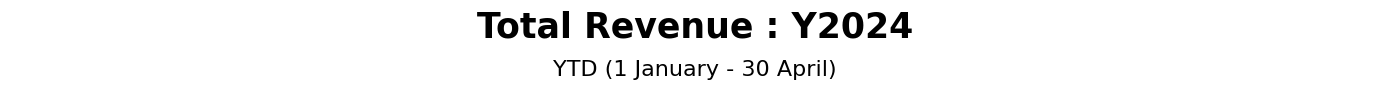

In [73]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Total Revenue : Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"YTD (1 January - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

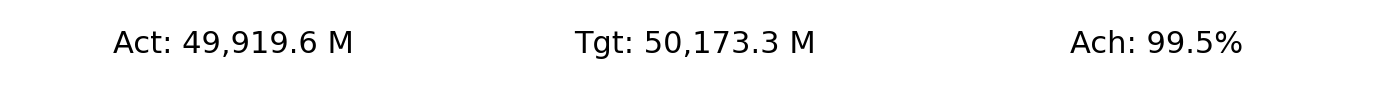

In [74]:
''' YTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
# ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(ytd_act,',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(ytd_tgt,',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

# ax4.text(0.5, 0.5, f"YoY: {format(ytd_yoy,',.1%')}", size=22, ha='center', va='center')
# ax4.spines[['top','left','right','bottom']].set_visible(False)
# ax4.set_axis_off()

fig.tight_layout()
plt.show()

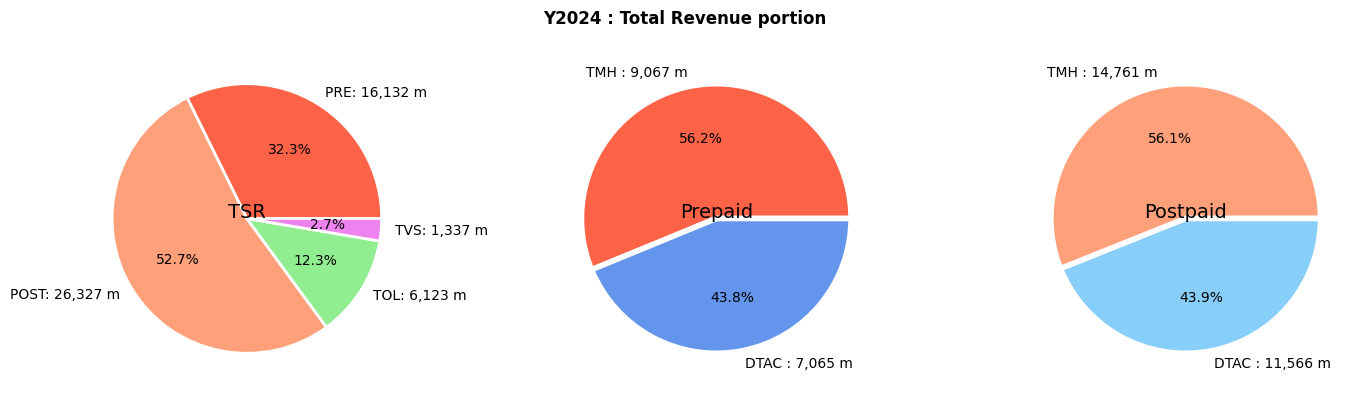

In [75]:
''' Revenue Portion Chart '''

fig = plt.figure(figsize=(14.3, 4))
fig.suptitle(f'Y{curr_yr} : Total Revenue portion', weight='bold')
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([y_yr_act_pre.sum(), y_yr_act_post.sum(), y_yr_act_tol.sum(), y_yr_act_tvs.sum()])
mylabels = [f"PRE: {format(y[0],',.0f')} m", f"POST: {format(y[1],',.0f')} m", f"TOL: {format(y[2],',.0f')} m", f"TVS: {format(y[3],',.0f')} m"]
mycolors = ["tomato", "lightsalmon", "lightgreen", "violet",  "mediumpurple"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 2, "edgecolor": "white"})
ax1.text(0, 0, 'TSR', ha='center', fontsize=14)

''' ax2 '''
y = np.array([y_yr_act_pre_tmh.sum(), y_yr_act_pre_dtac.sum()])
mylabels = [f"TMH : {format(y[0],',.0f')} m", f"DTAC : {format(y[1],',.0f')} m"]
mycolors = ["tomato", "cornflowerblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.text(0, 0, 'Prepaid', ha='center', fontsize=14)

''' ax3 '''
y = np.array([y_yr_act_post_tmh.sum(), y_yr_act_post_dtac.sum()])
mylabels = [f"TMH : {format(y[0],',.0f')} m", f"DTAC : {format(y[1],',.0f')} m"]
mycolors = ["lightsalmon", "lightskyblue"]
ax3.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax3.text(0, 0, 'Postpaid', ha='center', fontsize=14)

fig.tight_layout()
plt.show()

## ** Monthly **

### MTH : Aggregation

In [76]:
''' Create Dataframe '''

df_agg_s_mth = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_mth = df_agg_n.loc[df_agg_n.groupby('TM_KEY_MTH')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_mth = pd.concat([df_agg_s_mth, df_agg_n_mth])

''' Aggregation '''
df_rev_mth['%ACHV'] = df_rev_mth['ACT_SNAP'] / df_rev_mth['TGT_SNAP']
df_rev_mth['GAP'] = df_rev_mth['ACT_SNAP'] - df_rev_mth['TGT_SNAP']
df_rev_mth['LAST_ACT'] = df_rev_mth.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_mth['DIFF'] = df_rev_mth['ACT_SNAP'] - df_rev_mth['LAST_ACT']
df_rev_mth['%MOM'] = (df_rev_mth['ACT_SNAP'] / df_rev_mth['LAST_ACT']) - 1

df_rev_mth.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,AGG_TYPE,ACT_SNAP,TGT_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%MOM
27,TB3R000100CORP,TOL Revenue,202404,April,S,1547.099839,1561.878267,0.990538,-14.778428,1550.197117,-3.097278,-0.001998
28,TB4R000100CORP,TVS Revenue,202401,January,S,368.209891,381.438896,0.965318,-13.229005,NaN,NaN,NaN
29,TB4R000100CORP,TVS Revenue,202402,February,S,364.033880,380.438896,0.956879,-16.405016,368.209891,-4.176011,-0.011341
30,TB4R000100CORP,TVS Revenue,202403,March,S,369.895669,379.438896,0.974849,-9.543227,364.033880,5.861788,0.016102
31,TB4R000100CORP,TVS Revenue,202404,April,S,234.918515,253.846453,0.925435,-18.927938,369.895669,-134.977154,-0.364906


In [77]:
''' Pivot by KPIS '''

df_rev_mth_agg = df_rev_mth.pivot(index=['TM_KEY_MTH', 'MTH_DESC'], columns='METRIC_NAME', 
                                  values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%MOM']).rename(columns=cols_dict).reset_index()
df_rev_mth_agg.tail(3)

TM_KEY_MTH  MTH_DESC     ACT_SNAP                            \
METRIC_NAME                              POST    POST_DTAC     POST_TMH   
1               202402  February  6573.328018  2886.648865  3686.679153   
2               202403     March  6546.767289  2888.375734  3658.391555   
3               202404     April  6573.444693  2880.091836  3693.352857   

                                                                             \
METRIC_NAME          PRE     PRE_DTAC      PRE_TMH          TOL         TVS   
1            3885.089472  1714.499359  2170.590113  1525.819365  364.033880   
2            4138.080896  1804.320877  2333.760019  1550.197117  369.895669   
3            3987.233063  1743.063676  2244.169387  1547.099839  234.918515   

             ...       DIFF                  %MOM                      \
METRIC_NAME  ...        TOL         TVS      POST POST_DTAC  POST_TMH   
1            ...  25.819462   -4.176011 -0.009111 -0.008447 -0.009630   
2            ...  24.377752    5.861788 -0.004041  0.000598 -0.007673   
3            ...  -3.097278 -134.977154  0.004075 -0.002868  0.009556   

                                                               
METRIC_NAME       PRE  PRE_DTAC   PRE_TMH       TOL       TVS  
1           -0.057403 -0.049315 -0.063695  0.017213 -0.011341  
2            0.065119  0.052389  0.075173  0.015977  0.016102  
3           -0.036454 -0.033950 -0.038389 -0.001998 -0.364906  

[3 rows x 58 columns]

In [78]:
''' Add column for BG Summary '''

df_rev_mth_agg['ACT_BG'] = df_rev_mth_agg['ACT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_mth_agg['TGT_BG'] = df_rev_mth_agg['TGT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_mth_agg['%ACHV_BG'] = df_rev_mth_agg['ACT_BG'] / df_rev_mth_agg['TGT_BG']
df_rev_mth_agg['GAP_BG'] = df_rev_mth_agg['ACT_BG'] - df_rev_mth_agg['TGT_BG']
df_rev_mth_agg['LAST_ACT_BG'] = df_rev_mth_agg['LAST_ACT'][list(bg_col_list)].sum(axis=1)
df_rev_mth_agg['DIFF_BG'] = np.where(df_rev_mth_agg['LAST_ACT_BG']<=0, 0, df_rev_mth_agg['ACT_BG']-df_rev_mth_agg['LAST_ACT_BG'])
df_rev_mth_agg['%MOM_BG'] = np.where(df_rev_mth_agg['LAST_ACT_BG']<=0, 0, (df_rev_mth_agg['ACT_BG']/df_rev_mth_agg['LAST_ACT_BG'])-1)

df_rev_mth_agg.tail(3)

TM_KEY_MTH  MTH_DESC     ACT_SNAP                            \
METRIC_NAME                              POST    POST_DTAC     POST_TMH   
1               202402  February  6573.328018  2886.648865  3686.679153   
2               202403     March  6546.767289  2888.375734  3658.391555   
3               202404     April  6573.444693  2880.091836  3693.352857   

                                                                             \
METRIC_NAME          PRE     PRE_DTAC      PRE_TMH          TOL         TVS   
1            3885.089472  1714.499359  2170.590113  1525.819365  364.033880   
2            4138.080896  1804.320877  2333.760019  1550.197117  369.895669   
3            3987.233063  1743.063676  2244.169387  1547.099839  234.918515   

             ...      %MOM                            ACT_BG        TGT_BG  \
METRIC_NAME  ...   PRE_TMH       TOL       TVS                               
1            ... -0.063695  0.017213 -0.011341  12348.270734  12390.088852   
2            ...  0.075173  0.015977  0.016102  12604.940970  12701.766417   
3            ... -0.038389 -0.001998 -0.364906  12342.696109  12499.127742   

             %ACHV_BG      GAP_BG   LAST_ACT_BG     DIFF_BG   %MOM_BG  
METRIC_NAME                                                            
1            0.996625  -41.818118  12623.663677 -275.392943 -0.021816  
2            0.992377  -96.825447  12348.270734  256.670236  0.020786  
3            0.987485 -156.431633  12604.940970 -262.244861 -0.020805  

[3 rows x 65 columns]

In [79]:
''' BG Month to Date Values '''

df_last_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==last_mth][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'ACT_BG', 'TGT_BG']].reset_index()
day_cnt_curr_mth = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_MTH']==curr_mth) & (df_rev_day_agg['ACT_BG']>0)]['TM_KEY_DAY'].unique())
# mtd_last_act_tmp = df_last_mth.head(day_cnt_curr_mth)['ACT_BG'].sum()
mtd_last_act = (df_last_mth['ACT_BG'].sum() / len(df_last_mth['TM_KEY_DAY'].unique())) * day_cnt_curr_mth
mtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['ACT_BG'].sum()
mtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['TGT_BG'].sum()
mtd_achv = mtd_act / mtd_tgt
mtd_mom = (mtd_act / mtd_last_act) - 1
mtd_act_gap = mtd_act - mtd_last_act

In [80]:
''' Month Chart Values '''

x_mth = df_rev_mth_agg['MTH_DESC']
x_mth_axis = np.arange(len(x_mth))

''' Actual '''
y_mth_act = df_rev_mth_agg['ACT_BG']
y_mth_act_post = df_rev_mth_agg['ACT_SNAP']['POST']
y_mth_act_post_dtac = df_rev_mth_agg['ACT_SNAP']['POST_DTAC']
y_mth_act_post_tmh = df_rev_mth_agg['ACT_SNAP']['POST_TMH']
y_mth_act_pre = df_rev_mth_agg['ACT_SNAP']['PRE']
y_mth_act_pre_dtac = df_rev_mth_agg['ACT_SNAP']['PRE_DTAC']
y_mth_act_pre_tmh = df_rev_mth_agg['ACT_SNAP']['PRE_TMH']
y_mth_act_tol = df_rev_mth_agg['ACT_SNAP']['TOL']
y_mth_act_tvs = df_rev_mth_agg['ACT_SNAP']['TVS']

''' Target '''
y_mth_tgt = df_rev_mth_agg['TGT_BG']
y_mth_tgt_post = df_rev_mth_agg['TGT_SNAP']['POST']
y_mth_tgt_post_dtac = df_rev_mth_agg['TGT_SNAP']['POST_DTAC']
y_mth_tgt_post_tmh = df_rev_mth_agg['TGT_SNAP']['POST_TMH']
y_mth_tgt_pre = df_rev_mth_agg['TGT_SNAP']['PRE']
y_mth_tgt_pre_dtac = df_rev_mth_agg['TGT_SNAP']['PRE_DTAC']
y_mth_tgt_pre_tmh = df_rev_mth_agg['TGT_SNAP']['PRE_TMH']
y_mth_tgt_tol = df_rev_mth_agg['TGT_SNAP']['TOL']
y_mth_tgt_tvs = df_rev_mth_agg['TGT_SNAP']['TVS']

''' % Achievement '''
y_mth_achv = df_rev_mth_agg['%ACHV_BG']
y_mth_achv_post = df_rev_mth_agg['%ACHV']['POST']
y_mth_achv_post_dtac = df_rev_mth_agg['%ACHV']['POST_DTAC']
y_mth_achv_post_tmh = df_rev_mth_agg['%ACHV']['POST_TMH']
y_mth_achv_pre = df_rev_mth_agg['%ACHV']['PRE']
y_mth_achv_pre_dtac = df_rev_mth_agg['%ACHV']['PRE_DTAC']
y_mth_achv_pre_tmh = df_rev_mth_agg['%ACHV']['PRE_TMH']
y_mth_achv_tol = df_rev_mth_agg['%ACHV']['TOL']
y_mth_achv_tvs = df_rev_mth_agg['%ACHV']['TVS']

''' Gap '''
y_mth_gap = df_rev_mth_agg['GAP_BG']
y_mth_gap_post = df_rev_mth_agg['GAP']['POST']
y_mth_gap_post_dtac = df_rev_mth_agg['GAP']['POST_DTAC']
y_mth_gap_post_tmh = df_rev_mth_agg['GAP']['POST_TMH']
y_mth_gap_pre = df_rev_mth_agg['GAP']['PRE']
y_mth_gap_pre_dtac = df_rev_mth_agg['GAP']['PRE_DTAC']
y_mth_gap_pre_tmh = df_rev_mth_agg['GAP']['PRE_TMH']
y_mth_gap_tol = df_rev_mth_agg['GAP']['TOL']
y_mth_gap_tvs = df_rev_mth_agg['GAP']['TVS']

''' Last Actual '''
y_mth_last_act = df_rev_mth_agg['LAST_ACT_BG']
y_mth_last_act_post = df_rev_mth_agg['LAST_ACT']['POST']
y_mth_last_act_post_dtac = df_rev_mth_agg['LAST_ACT']['POST_DTAC']
y_mth_last_act_post_tmh = df_rev_mth_agg['LAST_ACT']['POST_TMH']
y_mth_last_act_pre = df_rev_mth_agg['LAST_ACT']['PRE']
y_mth_last_act_pre_dtac = df_rev_mth_agg['LAST_ACT']['PRE_DTAC']
y_mth_last_act_pre_tmh = df_rev_mth_agg['LAST_ACT']['PRE_TMH']
y_mth_last_act_tol = df_rev_mth_agg['LAST_ACT']['TOL']
y_mth_last_act_tvs = df_rev_mth_agg['LAST_ACT']['TVS']

''' Diff Last Actual '''
y_mth_diff = df_rev_mth_agg['DIFF_BG']
y_mth_diff_post = df_rev_mth_agg['DIFF']['POST']
y_mth_diff_post_dtac = df_rev_mth_agg['DIFF']['POST_DTAC']
y_mth_diff_post_tmh = df_rev_mth_agg['DIFF']['POST_TMH']
y_mth_diff_pre = df_rev_mth_agg['DIFF']['PRE']
y_mth_diff_pre_dtac = df_rev_mth_agg['DIFF']['PRE_DTAC']
y_mth_diff_pre_tmh = df_rev_mth_agg['DIFF']['PRE_TMH']
y_mth_diff_tol = df_rev_mth_agg['DIFF']['TOL']
y_mth_diff_tvs = df_rev_mth_agg['DIFF']['TVS']

''' % MOM '''
y_mth_mom = df_rev_mth_agg['%MOM_BG']
y_mth_mom_post = df_rev_mth_agg['%MOM']['POST']
y_mth_mom_post_dtac = df_rev_mth_agg['%MOM']['POST_DTAC']
y_mth_mom_post_tmh = df_rev_mth_agg['%MOM']['POST_TMH']
y_mth_mom_pre = df_rev_mth_agg['%MOM']['PRE']
y_mth_mom_pre_dtac = df_rev_mth_agg['%MOM']['PRE_DTAC']
y_mth_mom_pre_tmh = df_rev_mth_agg['%MOM']['PRE_TMH']
y_mth_mom_tol = df_rev_mth_agg['%MOM']['TOL']
y_mth_mom_tvs = df_rev_mth_agg['%MOM']['TVS']

### MTH : Visualizations

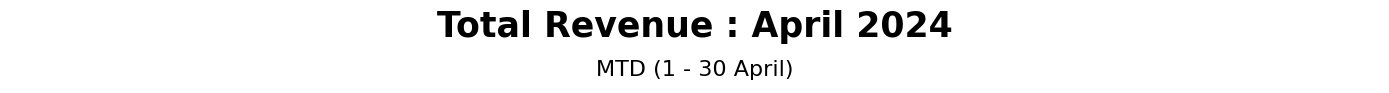

In [81]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Total Revenue : {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"MTD (1 - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

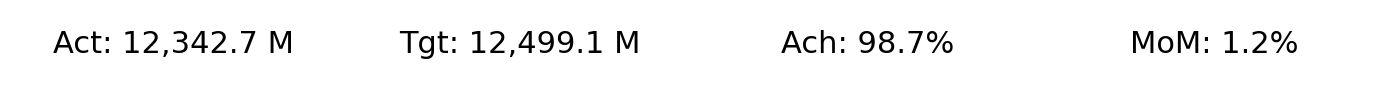

In [82]:
''' MTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(mtd_act,',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(mtd_tgt,',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

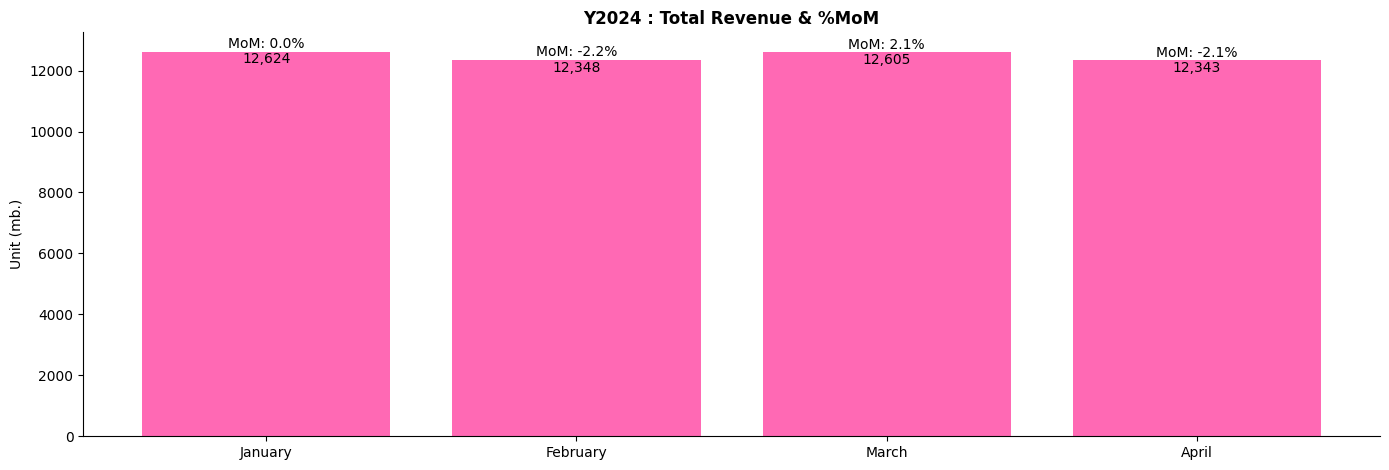

In [83]:
''' Total Revenue & MoM : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue & %MoM", weight='bold')
plt.bar(x_mth_axis, y_mth_act, label='Total', color='hotpink')
for i in x_mth_axis:
    plt.annotate(f"MoM: {format(y_mth_mom[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act[i]+20), ha='center', va='bottom')
    plt.annotate(format(y_mth_act[i],',.0f'), xy=(x_mth_axis[i], y_mth_act[i]-20), ha='center', va='top')

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
# plt.legend()
plt.tight_layout()
plt.show()

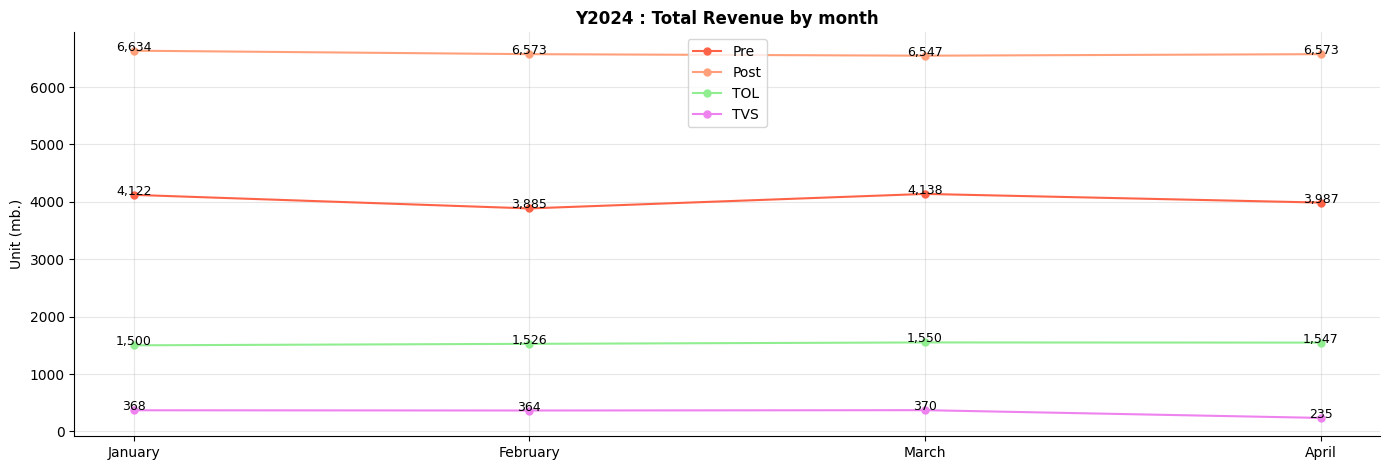

In [84]:
''' Revenue : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue by month", weight='bold')
plt.plot(x_mth_axis, y_mth_act_pre, marker='.', markeredgewidth=3, label='Pre', color='tomato')
plt.plot(x_mth_axis, y_mth_act_post, marker='.', markeredgewidth=3, label='Post', color='lightsalmon')
plt.plot(x_mth_axis, y_mth_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_mth_axis, y_mth_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
for i in x_mth_axis:
    plt.annotate(format(y_mth_act_pre[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_post[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_tol[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tol[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_tvs[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tvs[i]), ha='center', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

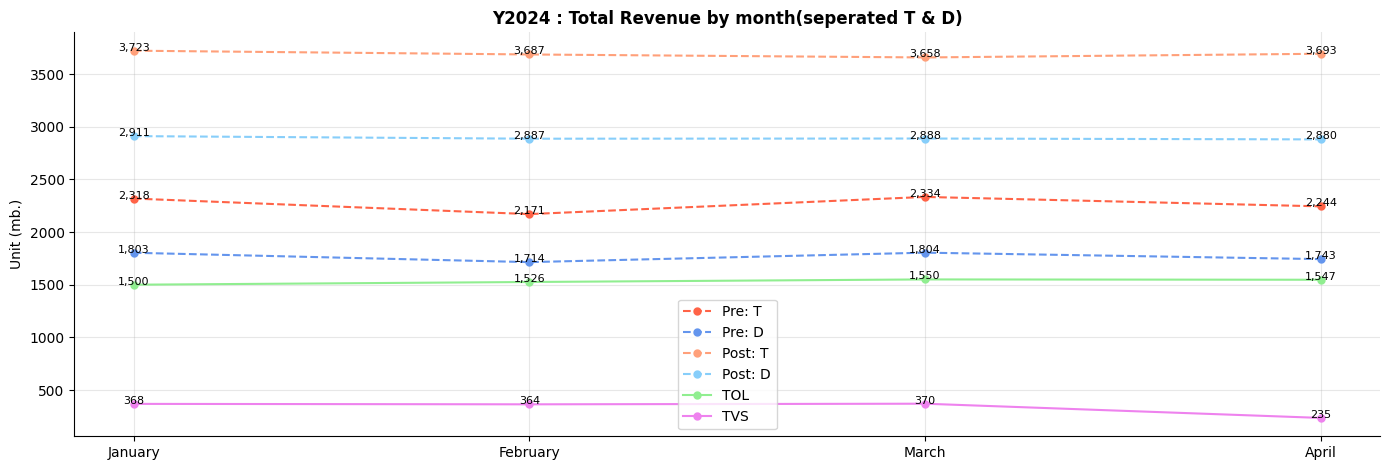

In [85]:
''' Revenue(Mobile separated by TMH, DTAC) : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue by month(seperated T & D)", weight='bold')
plt.plot(x_mth_axis, y_mth_act_pre_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: T', color='tomato')
plt.plot(x_mth_axis, y_mth_act_pre_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: D', color='cornflowerblue')
plt.plot(x_mth_axis, y_mth_act_post_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: T', color='lightsalmon')
plt.plot(x_mth_axis, y_mth_act_post_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: D', color='lightskyblue')
plt.plot(x_mth_axis, y_mth_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_mth_axis, y_mth_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
for i in x_mth_axis:
    plt.annotate(format(y_mth_act_pre_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_pre_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_post_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_post_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_tol[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_tvs[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tvs[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## ** Weekly **

### WK : Aggregation

In [86]:
''' Create Dataframe '''

df_agg_s_wk = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_wk = df_agg_n.loc[df_agg_n.groupby('TM_KEY_WK')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_wk = pd.concat([df_agg_s_wk, df_agg_n_wk])

# ''' Aggregation '''
df_rev_wk['%ACHV'] = df_rev_wk['ACT_SNAP'] / df_rev_wk['TGT_SNAP']
df_rev_wk['GAP'] = df_rev_wk['ACT_SNAP'] - df_rev_wk['TGT_SNAP']
df_rev_wk['LAST_ACT'] = df_rev_wk.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_wk['DIFF'] = df_rev_wk['ACT_SNAP'] - df_rev_wk['LAST_ACT']
df_rev_wk['%WOW'] = (df_rev_wk['ACT_SNAP'] / df_rev_wk['LAST_ACT']) - 1

df_rev_wk.tail(3)

,METRIC_CD,METRIC_NAME,TM_KEY_WK,WK_LABEL,AGG_TYPE,ACT_SNAP,TGT_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%WOW
141,TB4R000100CORP,TVS Revenue,2024016,16,S,50.224448,54.325522,0.924509,-4.101075,59.051632,-8.827184,-0.149482
142,TB4R000100CORP,TVS Revenue,2024017,17,S,73.672611,80.048388,0.920351,-6.375777,50.224448,23.448163,0.466868
143,TB4R000100CORP,TVS Revenue,2024018,18,S,0.000000,0.000000,NaN,0.000000,73.672611,-73.672611,-1.000000


In [87]:
''' Pivot by KPIS '''

df_rev_wk_agg = df_rev_wk.pivot(index=['TM_KEY_WK', 'WK_LABEL'], columns='METRIC_NAME', 
                                values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%WOW']).rename(columns=cols_dict).reset_index()
df_rev_wk_agg.tail(3)

TM_KEY_WK WK_LABEL     ACT_SNAP                           \
METRIC_NAME                            POST   POST_DTAC     POST_TMH   
15            2024016       16  1342.817680  593.250663   749.567017   
16            2024017       17  1769.481571  629.017683  1140.463888   
17            2024018       18   323.699568  295.432496    28.267072   

                                                                        ...  \
METRIC_NAME         PRE    PRE_DTAC     PRE_TMH         TOL        TVS  ...   
15           871.378627  382.546151  488.832476  327.657912  50.224448  ...   
16           890.203958  391.519857  498.684101  486.783629  73.672611  ...   
17           304.868037  129.400095  175.467942    0.000000   0.000000  ...   

                   DIFF                 %WOW                                \
METRIC_NAME         TOL        TVS      POST POST_DTAC  POST_TMH       PRE   
15           -65.632465  -8.827184 -0.119857 -0.059659 -0.162300 -0.044327   
16           159.125717  23.448163  0.317738  0.060290  0.521497  0.021604   
17          -486.783629 -73.672611 -0.817065 -0.530327 -0.975214 -0.657530   

                                                     
METRIC_NAME  PRE_DTAC   PRE_TMH       TOL       TVS  
15          -0.030674 -0.054746 -0.166880 -0.149482  
16           0.023458  0.020153  0.485646  0.466868  
17          -0.669493 -0.648138 -1.000000 -1.000000  

[3 rows x 58 columns]

In [88]:
''' Add column for BG Summary '''

df_rev_wk_agg['ACT_BG'] = df_rev_wk_agg['ACT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_wk_agg['TGT_BG'] = df_rev_wk_agg['TGT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_wk_agg['%ACHV_BG'] = df_rev_wk_agg['ACT_BG'] / df_rev_wk_agg['TGT_BG']
df_rev_wk_agg['GAP_BG'] = df_rev_wk_agg['ACT_BG'] - df_rev_wk_agg['TGT_BG']
df_rev_wk_agg['LAST_ACT_BG'] = df_rev_wk_agg['LAST_ACT'][list(bg_col_list)].sum(axis=1)
df_rev_wk_agg['DIFF_BG'] = np.where(df_rev_wk_agg['LAST_ACT_BG']<=0, 0, df_rev_wk_agg['ACT_BG']-df_rev_wk_agg['LAST_ACT_BG'])
df_rev_wk_agg['%WOW_BG'] = np.where(df_rev_wk_agg['LAST_ACT_BG']<=0, 0, (df_rev_wk_agg['ACT_BG']/df_rev_wk_agg['LAST_ACT_BG'])-1)

df_rev_wk_agg.tail(3)

TM_KEY_WK WK_LABEL     ACT_SNAP                           \
METRIC_NAME                            POST   POST_DTAC     POST_TMH   
15            2024016       16  1342.817680  593.250663   749.567017   
16            2024017       17  1769.481571  629.017683  1140.463888   
17            2024018       18   323.699568  295.432496    28.267072   

                                                                        ...  \
METRIC_NAME         PRE    PRE_DTAC     PRE_TMH         TOL        TVS  ...   
15           871.378627  382.546151  488.832476  327.657912  50.224448  ...   
16           890.203958  391.519857  498.684101  486.783629  73.672611  ...   
17           304.868037  129.400095  175.467942    0.000000   0.000000  ...   

                 %WOW                           ACT_BG       TGT_BG  %ACHV_BG  \
METRIC_NAME   PRE_TMH       TOL       TVS                                       
15          -0.054746 -0.166880 -0.149482  2592.078667  2705.919225  0.957929   
16           0.020153  0.485646  0.466868  3220.141769  3292.181502  0.978118   
17          -0.648138 -1.000000 -1.000000   628.567605   590.746844  1.064022   

                 GAP_BG  LAST_ACT_BG      DIFF_BG   %WOW_BG  
METRIC_NAME                                                  
15          -113.840558  2889.818516  -297.739849 -0.103031  
16           -72.039734  2592.078667   628.063102  0.242301  
17            37.820761  3220.141769 -2591.574163 -0.804801  

[3 rows x 65 columns]

In [89]:
''' BG Week to Date Values '''

df_last_wk = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==last_wk][['TM_KEY_DAY', 'TM_KEY_WK', 'ACT_BG', 'TGT_BG']].reset_index()
day_cnt_curr_wk = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_WK']==curr_wk) & (df_rev_day_agg['ACT_BG']>0)]['TM_KEY_DAY'].unique())

# wtd_last_act_tmp = df_last_wk.head(day_cnt_curr_wk)['ACT_BG'].sum()
wtd_last_act = (df_last_wk['ACT_BG'].sum() / len(df_last_wk['TM_KEY_DAY'].unique())) * day_cnt_curr_wk
wtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['ACT_BG'].sum()
wtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['TGT_BG'].sum()
wtd_achv = wtd_act / wtd_tgt
wtd_wow = (wtd_act / wtd_last_act) - 1
wtd_act_gap = wtd_act - wtd_last_act

In [90]:
''' Week Chart Values '''

x_wk = df_rev_wk_agg['WK_LABEL']
x_wk_axis = np.arange(len(x_wk))

''' Actual '''
y_wk_act = df_rev_wk_agg['ACT_BG']
y_wk_act_post = df_rev_wk_agg['ACT_SNAP']['POST']
y_wk_act_post_dtac = df_rev_wk_agg['ACT_SNAP']['POST_DTAC']
y_wk_act_post_tmh = df_rev_wk_agg['ACT_SNAP']['POST_TMH']
y_wk_act_pre = df_rev_wk_agg['ACT_SNAP']['PRE']
y_wk_act_pre_dtac = df_rev_wk_agg['ACT_SNAP']['PRE_DTAC']
y_wk_act_pre_tmh = df_rev_wk_agg['ACT_SNAP']['PRE_TMH']
y_wk_act_tol = df_rev_wk_agg['ACT_SNAP']['TOL']
y_wk_act_tvs = df_rev_wk_agg['ACT_SNAP']['TVS']

''' Target '''
y_wk_tgt = df_rev_wk_agg['TGT_BG']
y_wk_tgt_post = df_rev_wk_agg['TGT_SNAP']['POST']
y_wk_tgt_post_dtac = df_rev_wk_agg['TGT_SNAP']['POST_DTAC']
y_wk_tgt_post_tmh = df_rev_wk_agg['TGT_SNAP']['POST_TMH']
y_wk_tgt_pre = df_rev_wk_agg['TGT_SNAP']['PRE']
y_wk_tgt_pre_dtac = df_rev_wk_agg['TGT_SNAP']['PRE_DTAC']
y_wk_tgt_pre_tmh = df_rev_wk_agg['TGT_SNAP']['PRE_TMH']
y_wk_tgt_tol = df_rev_wk_agg['TGT_SNAP']['TOL']
y_wk_tgt_tvs = df_rev_wk_agg['TGT_SNAP']['TVS']

''' % Achievement '''
y_wk_achv = df_rev_wk_agg['%ACHV_BG']
y_wk_achv_post = df_rev_wk_agg['%ACHV']['POST']
y_wk_achv_post_dtac = df_rev_wk_agg['%ACHV']['POST_DTAC']
y_wk_achv_post_tmh = df_rev_wk_agg['%ACHV']['POST_TMH']
y_wk_achv_pre = df_rev_wk_agg['%ACHV']['PRE']
y_wk_achv_pre_dtac = df_rev_wk_agg['%ACHV']['PRE_DTAC']
y_wk_achv_pre_tmh = df_rev_wk_agg['%ACHV']['PRE_TMH']
y_wk_achv_tol = df_rev_wk_agg['%ACHV']['TOL']
y_wk_achv_tvs = df_rev_wk_agg['%ACHV']['TVS']

''' Gap '''
y_wk_gap = df_rev_wk_agg['GAP_BG']
y_wk_gap_post = df_rev_wk_agg['GAP']['POST']
y_wk_gap_post_dtac = df_rev_wk_agg['GAP']['POST_DTAC']
y_wk_gap_post_tmh = df_rev_wk_agg['GAP']['POST_TMH']
y_wk_gap_pre = df_rev_wk_agg['GAP']['PRE']
y_wk_gap_pre_dtac = df_rev_wk_agg['GAP']['PRE_DTAC']
y_wk_gap_pre_tmh = df_rev_wk_agg['GAP']['PRE_TMH']
y_wk_gap_tol = df_rev_wk_agg['GAP']['TOL']
y_wk_gap_tvs = df_rev_wk_agg['GAP']['TVS']

''' Last Actual '''
y_wk_last_act = df_rev_wk_agg['LAST_ACT_BG']
y_wk_last_act_post = df_rev_wk_agg['LAST_ACT']['POST']
y_wk_last_act_post_dtac = df_rev_wk_agg['LAST_ACT']['POST_DTAC']
y_wk_last_act_post_tmh = df_rev_wk_agg['LAST_ACT']['POST_TMH']
y_wk_last_act_pre = df_rev_wk_agg['LAST_ACT']['PRE']
y_wk_last_act_pre_dtac = df_rev_wk_agg['LAST_ACT']['PRE_DTAC']
y_wk_last_act_pre_tmh = df_rev_wk_agg['LAST_ACT']['PRE_TMH']
y_wk_last_act_tol = df_rev_wk_agg['LAST_ACT']['TOL']
y_wk_last_act_tvs = df_rev_wk_agg['LAST_ACT']['TVS']

''' Diff Last Actual '''
y_wk_diff = df_rev_wk_agg['DIFF_BG']
y_wk_diff_post = df_rev_wk_agg['DIFF']['POST']
y_wk_diff_post_dtac = df_rev_wk_agg['DIFF']['POST_DTAC']
y_wk_diff_post_tmh = df_rev_wk_agg['DIFF']['POST_TMH']
y_wk_diff_pre = df_rev_wk_agg['DIFF']['PRE']
y_wk_diff_pre_dtac = df_rev_wk_agg['DIFF']['PRE_DTAC']
y_wk_diff_pre_tmh = df_rev_wk_agg['DIFF']['PRE_TMH']
y_wk_diff_tol = df_rev_wk_agg['DIFF']['TOL']
y_wk_diff_tvs = df_rev_wk_agg['DIFF']['TVS']

''' % WOW '''
y_wk_wow = df_rev_wk_agg['%WOW_BG']
y_wk_wow_post = df_rev_wk_agg['%WOW']['POST']
y_wk_wow_post_dtac = df_rev_wk_agg['%WOW']['POST_DTAC']
y_wk_wow_post_tmh = df_rev_wk_agg['%WOW']['POST_TMH']
y_wk_wow_pre = df_rev_wk_agg['%WOW']['PRE']
y_wk_wow_pre_dtac = df_rev_wk_agg['%WOW']['PRE_DTAC']
y_wk_wow_pre_tmh = df_rev_wk_agg['%WOW']['PRE_TMH']
y_wk_wow_tol = df_rev_wk_agg['%WOW']['TOL']
y_wk_wow_tvs = df_rev_wk_agg['%WOW']['TVS']

### WK : Visualizations

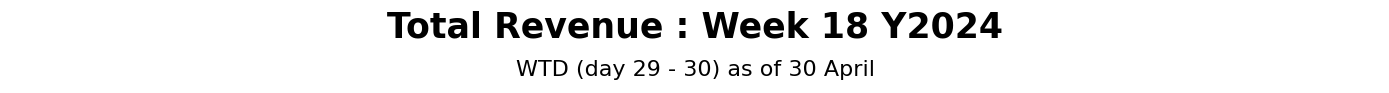

In [91]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Total Revenue : Week {curr_wk_label} Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"WTD (day {wk_day_start} - {wk_day_end}) as of {curr_day_label} {curr_mth_desc}", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

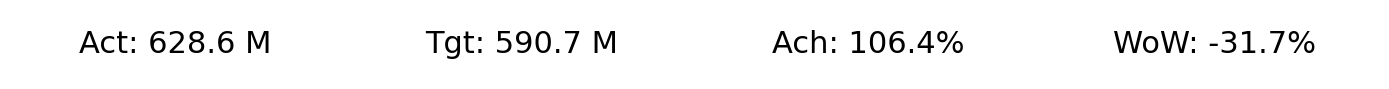

In [92]:
''' WTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(wtd_act,',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(wtd_tgt,',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(wtd_wow,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

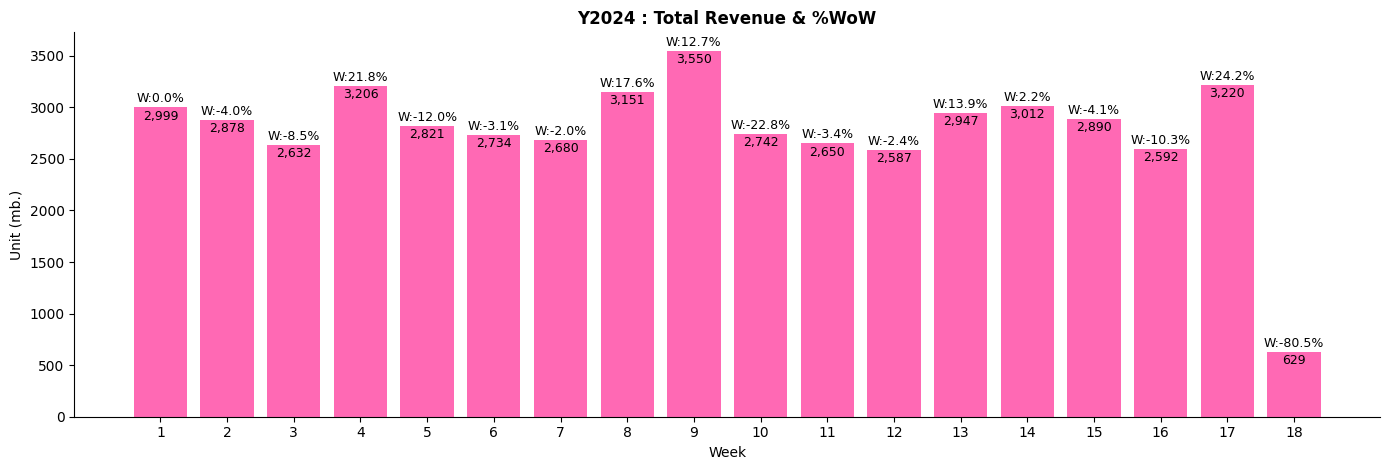

In [93]:
''' Total Revenue & WoW : WK Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue & %WoW", weight='bold')
plt.bar(x_wk_axis, y_wk_act, label='Total', color='hotpink')
for i in x_wk_axis:
    plt.annotate(f"W:{format(y_wk_wow[i],',.1%')}", xy=(x_wk_axis[i], y_wk_act[i]+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_wk_act[i],',.0f'), xy=(x_wk_axis[i], y_wk_act[i]-20), ha='center', va='top', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xlabel('Week')
plt.xticks(x_wk_axis, x_wk)
plt.tight_layout()
plt.show()

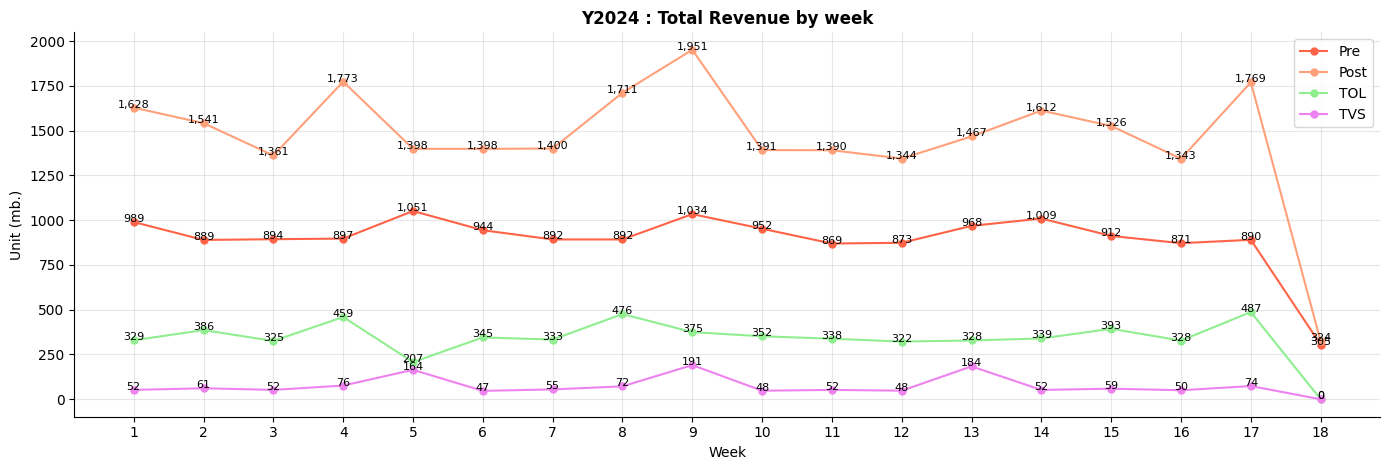

In [94]:
''' Revenue : WK Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue by week", weight='bold')
plt.plot(x_wk_axis, y_wk_act_pre, marker='.', markeredgewidth=3, label='Pre', color='tomato')
plt.plot(x_wk_axis, y_wk_act_post, marker='.', markeredgewidth=3, label='Post', color='lightsalmon')
plt.plot(x_wk_axis, y_wk_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_wk_axis, y_wk_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
for i in x_wk_axis:
    plt.annotate(format(y_wk_act_pre[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_pre[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_post[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_post[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tol[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tvs[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tvs[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel('Week')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

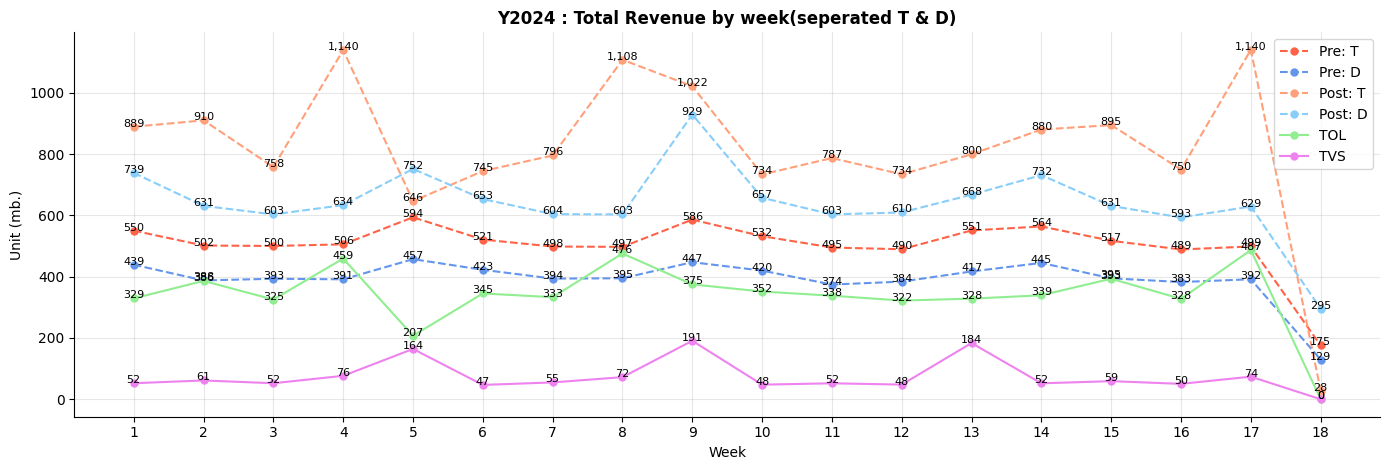

In [95]:
''' Revenue(Mobile separated by TMH, DTAC) : WK Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue by week(seperated T & D)", weight='bold')
plt.plot(x_wk_axis, y_wk_act_pre_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: T', color='tomato')
plt.plot(x_wk_axis, y_wk_act_pre_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: D', color='cornflowerblue')
plt.plot(x_wk_axis, y_wk_act_post_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: T', color='lightsalmon')
plt.plot(x_wk_axis, y_wk_act_post_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: D', color='lightskyblue')
plt.plot(x_wk_axis, y_wk_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_wk_axis, y_wk_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
for i in x_wk_axis:
    plt.annotate(format(y_wk_act_pre_tmh[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_pre_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_pre_dtac[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_pre_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_post_tmh[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_post_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_post_dtac[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_post_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tol[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tvs[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tvs[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel('Week')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## ** Daily (MTD) **

### DAY : Aggregation

In [96]:
''' Create Dataframe '''

df_rev_day_curr_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth].reset_index()

df_rev_day_curr_mth_clean = df_rev_day_curr_mth[df_rev_day_curr_mth['ACT_BG'] > 0].reset_index()

df_rev_day_curr_day = df_rev_day_curr_mth_clean.loc[df_rev_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

df_rev_day_last_day = df_rev_day_curr_mth_clean.shift().loc[df_rev_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

In [97]:
''' DTD Values '''

''' Last Period : Values '''
last_day_rev = df_rev_day_last_day['ACT_BG'].sum()

''' TOTAL : Values '''
dtd_rev = df_rev_day_curr_day['ACT_BG'].sum()
dtd_tgt = df_rev_day_curr_day['TGT_BG'].sum()
dtd_achv = dtd_rev / dtd_tgt
dtd_last_rev = df_rev_day_last_day['ACT_BG'].sum()
dtd_dod = (dtd_rev / dtd_last_rev) - 1
dtd_gap = dtd_rev - dtd_last_rev

In [98]:
''' Day Chart Values '''

x_day = df_rev_day_curr_mth['DAY_LABEL']
x_day_axis = np.arange(len(x_day))

''' Actual '''
y_day_act = df_rev_day_curr_mth['ACT_BG']
y_day_act_post = df_rev_day_curr_mth['ACT_SNAP']['POST']
y_day_act_post_dtac = df_rev_day_curr_mth['ACT_SNAP']['POST_DTAC']
y_day_act_post_tmh = df_rev_day_curr_mth['ACT_SNAP']['POST_TMH']
y_day_act_pre = df_rev_day_curr_mth['ACT_SNAP']['PRE']
y_day_act_pre_dtac = df_rev_day_curr_mth['ACT_SNAP']['PRE_DTAC']
y_day_act_pre_tmh = df_rev_day_curr_mth['ACT_SNAP']['PRE_TMH']
y_day_act_tol = df_rev_day_curr_mth['ACT_SNAP']['TOL']
y_day_act_tvs = df_rev_day_curr_mth['ACT_SNAP']['TVS']

''' Target '''
y_day_tgt = df_rev_day_curr_mth['TGT_BG']
y_day_tgt_post = df_rev_day_curr_mth['TGT_SNAP']['POST']
y_day_tgt_post_dtac = df_rev_day_curr_mth['TGT_SNAP']['POST_DTAC']
y_day_tgt_post_tmh = df_rev_day_curr_mth['TGT_SNAP']['POST_TMH']
y_day_tgt_pre = df_rev_day_curr_mth['TGT_SNAP']['PRE']
y_day_tgt_pre_dtac = df_rev_day_curr_mth['TGT_SNAP']['PRE_DTAC']
y_day_tgt_pre_tmh = df_rev_day_curr_mth['TGT_SNAP']['PRE_TMH']
y_day_tgt_tol = df_rev_day_curr_mth['TGT_SNAP']['TOL']
y_day_tgt_tvs = df_rev_day_curr_mth['TGT_SNAP']['TVS']

''' % Achievement '''
y_day_achv = df_rev_day_curr_mth['%ACHV_BG']
y_day_achv_post = df_rev_day_curr_mth['%ACHV']['POST']
y_day_achv_post_dtac = df_rev_day_curr_mth['%ACHV']['POST_DTAC']
y_day_achv_post_tmh = df_rev_day_curr_mth['%ACHV']['POST_TMH']
y_day_achv_pre = df_rev_day_curr_mth['%ACHV']['PRE']
y_day_achv_pre_dtac = df_rev_day_curr_mth['%ACHV']['PRE_DTAC']
y_day_achv_pre_tmh = df_rev_day_curr_mth['%ACHV']['PRE_TMH']
y_day_achv_tol = df_rev_day_curr_mth['%ACHV']['TOL']
y_day_achv_tvs = df_rev_day_curr_mth['%ACHV']['TVS']

''' Gap '''
y_day_gap = df_rev_day_curr_mth['GAP_BG']
y_day_gap_post = df_rev_day_curr_mth['GAP']['POST']
y_day_gap_post_dtac = df_rev_day_curr_mth['GAP']['POST_DTAC']
y_day_gap_post_tmh = df_rev_day_curr_mth['GAP']['POST_TMH']
y_day_gap_pre = df_rev_day_curr_mth['GAP']['PRE']
y_day_gap_pre_dtac = df_rev_day_curr_mth['GAP']['PRE_DTAC']
y_day_gap_pre_tmh = df_rev_day_curr_mth['GAP']['PRE_TMH']
y_day_gap_tol = df_rev_day_curr_mth['GAP']['TOL']
y_day_gap_tvs = df_rev_day_curr_mth['GAP']['TVS']

''' Last Actual '''
y_day_last_act = df_rev_day_curr_mth['LAST_ACT_BG']
y_day_last_act_post = df_rev_day_curr_mth['LAST_ACT']['POST']
y_day_last_act_post_dtac = df_rev_day_curr_mth['LAST_ACT']['POST_DTAC']
y_day_last_act_post_tmh = df_rev_day_curr_mth['LAST_ACT']['POST_TMH']
y_day_last_act_pre = df_rev_day_curr_mth['LAST_ACT']['PRE']
y_day_last_act_pre_dtac = df_rev_day_curr_mth['LAST_ACT']['PRE_DTAC']
y_day_last_act_pre_tmh = df_rev_day_curr_mth['LAST_ACT']['PRE_TMH']
y_day_last_act_tol = df_rev_day_curr_mth['LAST_ACT']['TOL']
y_day_last_act_tvs = df_rev_day_curr_mth['LAST_ACT']['TVS']

''' Diff Last Actual '''
y_day_diff = df_rev_day_curr_mth['DIFF_BG']
y_day_diff_post = df_rev_day_curr_mth['DIFF']['POST']
y_day_diff_post_dtac = df_rev_day_curr_mth['DIFF']['POST_DTAC']
y_day_diff_post_tmh = df_rev_day_curr_mth['DIFF']['POST_TMH']
y_day_diff_pre = df_rev_day_curr_mth['DIFF']['PRE']
y_day_diff_pre_dtac = df_rev_day_curr_mth['DIFF']['PRE_DTAC']
y_day_diff_pre_tmh = df_rev_day_curr_mth['DIFF']['PRE_TMH']
y_day_diff_tol = df_rev_day_curr_mth['DIFF']['TOL']
y_day_diff_tvs = df_rev_day_curr_mth['DIFF']['TVS']

''' % DOD '''
y_day_dod = df_rev_day_curr_mth['%DOD_BG']
y_day_dod_post = df_rev_day_curr_mth['%DOD']['POST']
y_day_dod_post_dtac = df_rev_day_curr_mth['%DOD']['POST_DTAC']
y_day_dod_post_tmh = df_rev_day_curr_mth['%DOD']['POST_TMH']
y_day_dod_pre = df_rev_day_curr_mth['%DOD']['PRE']
y_day_dod_pre_dtac = df_rev_day_curr_mth['%DOD']['PRE_DTAC']
y_day_dod_pre_tmh = df_rev_day_curr_mth['%DOD']['PRE_TMH']
y_day_dod_tol = df_rev_day_curr_mth['%DOD']['TOL']
y_day_dod_tvs = df_rev_day_curr_mth['%DOD']['TVS']

### DAY : Visualizations

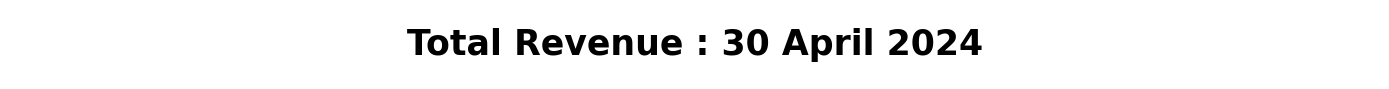

In [99]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[:, :])

ax1.text(0.5, 0.5, f"Total Revenue : {curr_day_label} {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

fig.tight_layout()
plt.show()

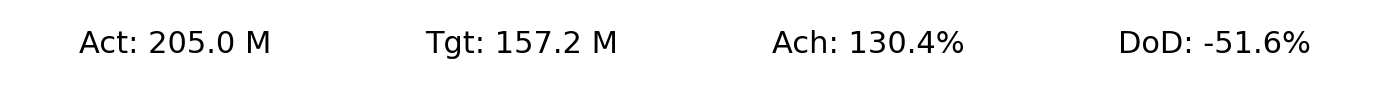

In [100]:
''' DTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(dtd_rev,',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(dtd_tgt,',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(dtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(dtd_dod,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

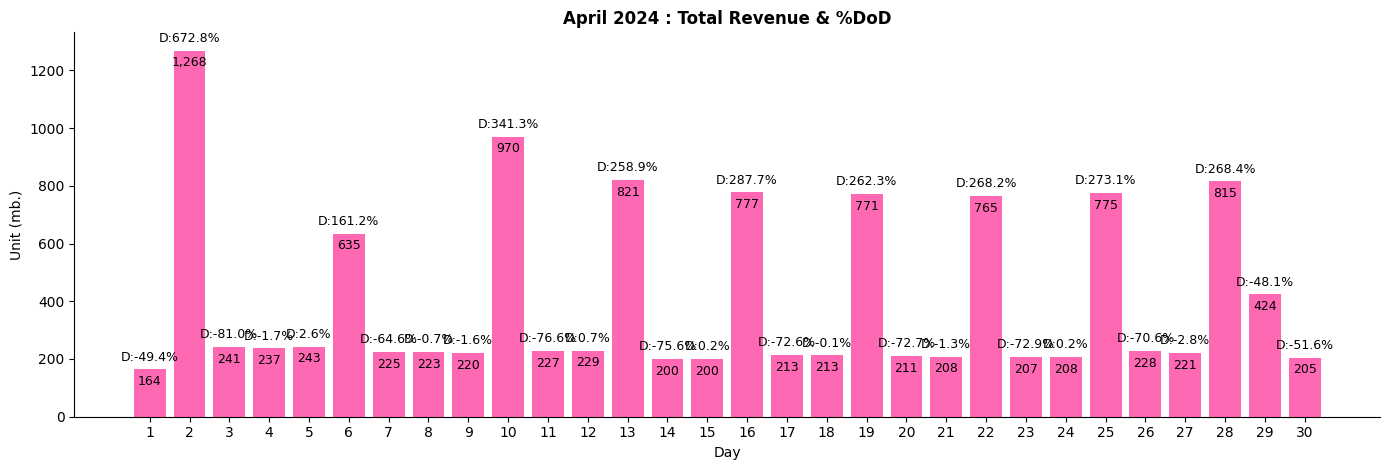

In [101]:
''' Total Revenue & DoD : DAY Chart '''

plt.figure().set_figwidth(14)

plt.title(f"{curr_mth_desc} {curr_yr} : Total Revenue & %DoD", fontdict={'fontweight': 'bold'})
plt.bar(x_day_axis, y_day_act, label='Total', color='hotpink')
for i in x_day_axis:
    plt.annotate(f"D:{format(y_day_dod[i],',.1%')}", xy=(x_day_axis[i], y_day_act[i]+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_day_act[i],',.0f'), xy=(x_day_axis[i], y_day_act[i]-20), ha='center', va='top', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xlabel(f'Day')
plt.xticks(x_day_axis, x_day)
plt.tight_layout()
plt.show()

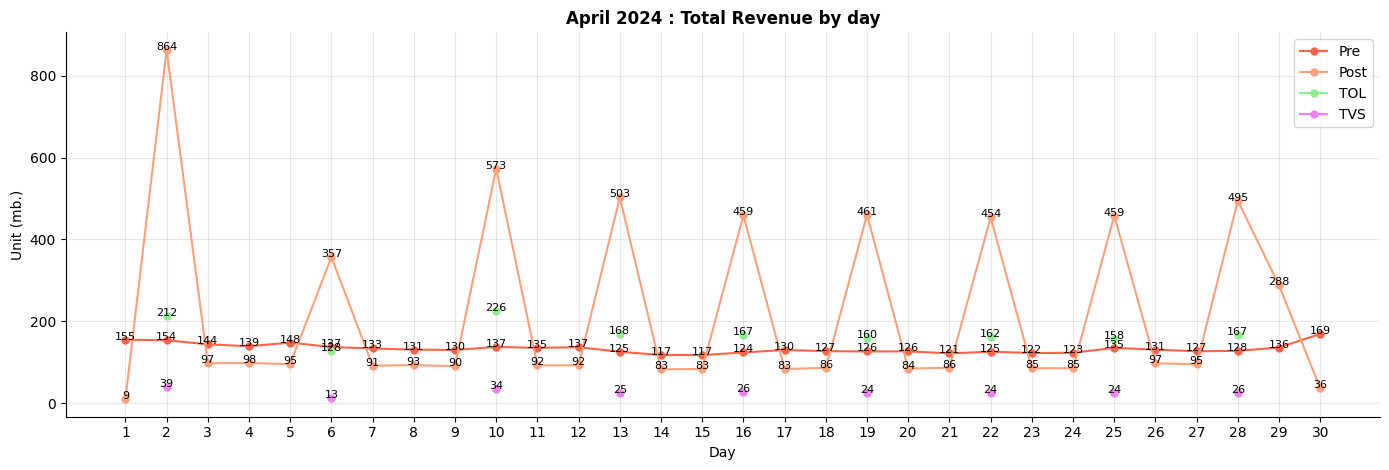

In [102]:
''' Revenue : DAY Chart '''

plt.figure().set_figwidth(14)

plt.title(f"{curr_mth_desc} {curr_yr} : Total Revenue by day", fontdict={'fontweight': 'bold'})
plt.plot(x_day_axis, y_day_act_pre, marker='.', markeredgewidth=3, label='Pre', color='tomato')
plt.plot(x_day_axis, y_day_act_post, marker='.', markeredgewidth=3, label='Post', color='lightsalmon')
plt.plot(x_day_axis, y_day_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_day_axis, y_day_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
for i in x_day_axis:
    plt.annotate(format(y_day_act_pre[i],',.0f'), xy=(x_day_axis[i], y_day_act_pre[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_post[i],',.0f'), xy=(x_day_axis[i], y_day_act_post[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tol[i],',.0f'), xy=(x_day_axis[i], y_day_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tvs[i],',.0f'), xy=(x_day_axis[i], y_day_act_tvs[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel(f'Day')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

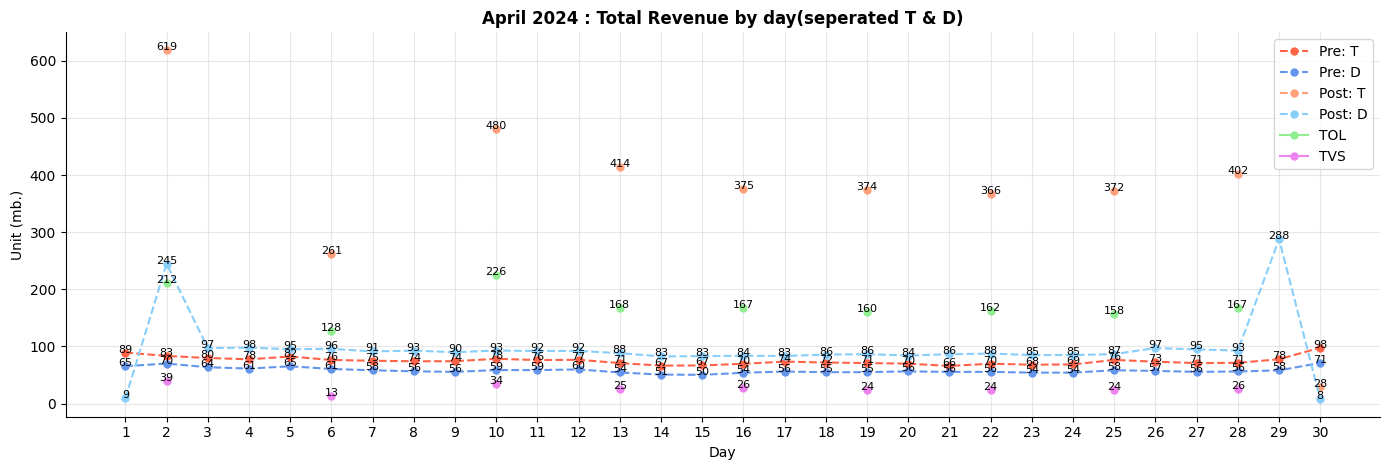

In [103]:
''' Revenue(Mobile separated by TMH, DTAC) : DAY Chart '''

plt.figure().set_figwidth(14)

plt.title(f"{curr_mth_desc} {curr_yr} : Total Revenue by day(seperated T & D)", fontdict={'fontweight': 'bold'})
plt.plot(x_day_axis, y_day_act_pre_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: T', color='tomato')
plt.plot(x_day_axis, y_day_act_pre_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: D', color='cornflowerblue')
plt.plot(x_day_axis, y_day_act_post_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: T', color='lightsalmon')
plt.plot(x_day_axis, y_day_act_post_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: D', color='lightskyblue')
plt.plot(x_day_axis, y_day_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_day_axis, y_day_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
for i in x_day_axis:
    plt.annotate(format(y_day_act_pre_tmh[i],',.0f'), xy=(x_day_axis[i], y_day_act_pre_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_pre_dtac[i],',.0f'), xy=(x_day_axis[i], y_day_act_pre_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_post_tmh[i],',.0f'), xy=(x_day_axis[i], y_day_act_post_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_post_dtac[i],',.0f'), xy=(x_day_axis[i], y_day_act_post_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tol[i],',.0f'), xy=(x_day_axis[i], y_day_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tvs[i],',.0f'), xy=(x_day_axis[i], y_day_act_tvs[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel(f'Day')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Generate Output Data

In [104]:
# df_rev_day.to_excel('../data/interim/df_rev_day.xlsx', index=False)
# df_rev_yr.to_excel('../data/interim/df_rev_yr.xlsx', index=False)
# df_rev_mth.to_excel('../data/interim/df_rev_mth.xlsx', index=False)
# df_rev_wk.to_excel('../data/interim/df_rev_wk.xlsx', index=False)